# Import

In [11]:
%load_ext autoreload
%autoreload 2
import os

import scanpy as sc

import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import pandas as pd

import sys
# sys.path.append('../')
# from src.inVAE.model import FinVAE
from inVAE import FinVAE

import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

sc.set_figure_params(dpi=200,figsize=(6,4),fontsize=10,frameon=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.version.cuda

'11.7'

# Load Data

In [3]:
data_dir = '/lustre/scratch126/cellgen/team205/dp26/Lung_multiome_project/reference_atlas/lung_5loc_sc_sn_cellxgene_allgenes_05122022.h5ad'
processed_adata = sc.read(data_dir)

In [4]:
processed_adata

AnnData object with n_obs × n_vars = 193108 × 1147
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'gene_ids-0', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'gene_ids-1', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'feature_types-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection', 'mean', 'std'
    uns: 'Celltypes_colors', 'Celltypes_int_F_colors', 'Celltypes_int_colors', 'Celltypes_int_updB_colors', 'Celltypes_master_high_colors', 'ID_colors', 'Loc_true_colors', 'hvg', 'leiden', 'leiden_co

In [4]:
data_dir = '/lustre/scratch126/cellgen/team205/dp26/Lung_multiome_project/reference_atlas/lung_5loc_sc_sn_raw_counts_cellxgene.h5ad'
adata = sc.read(data_dir)

In [5]:
adata

AnnData object with n_obs × n_vars = 193108 × 33538
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch'
    var: 'gene_ids', 'feature_types'

In [10]:
sc.pp.filter_genes(adata, min_cells=5)

In [13]:
# Normalize total counts per cell
adata.raw = adata.copy()
adata.layers["counts"] = adata[adata.obs_names, adata.var_names].X.todense().copy()

sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
# Logarithmize the data matrix
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata,n_top_genes=4000,batch_key='Sample')
adata = adata[:,adata.var.highly_variable==True]

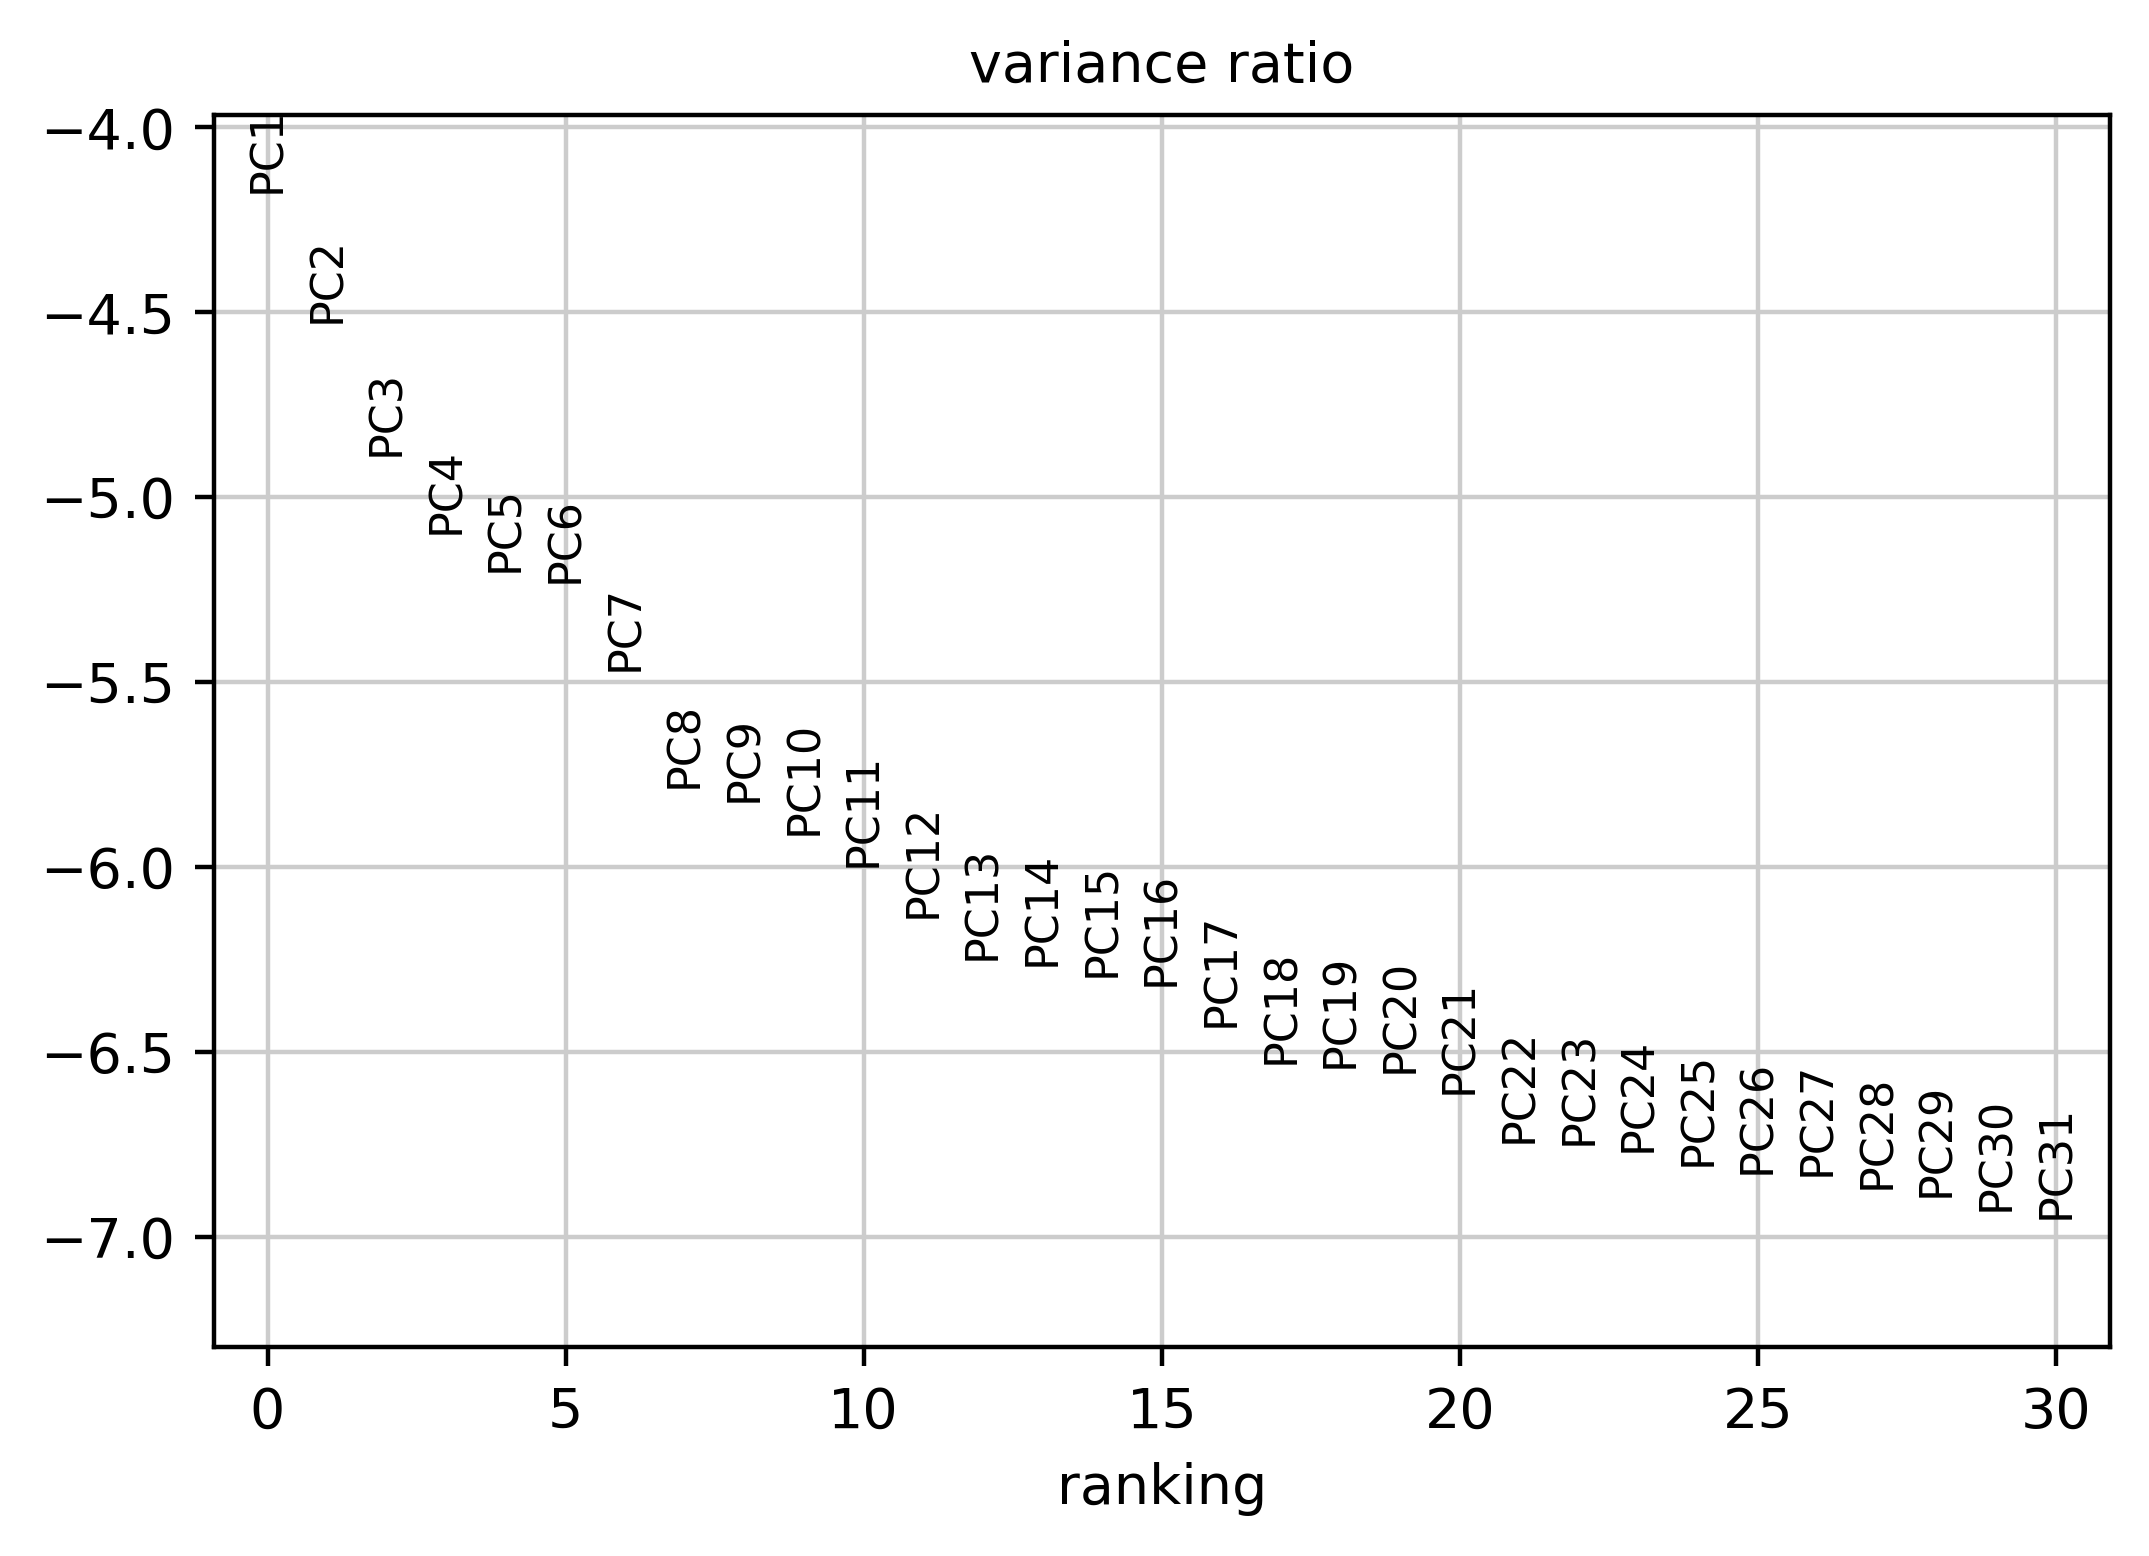

/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/si

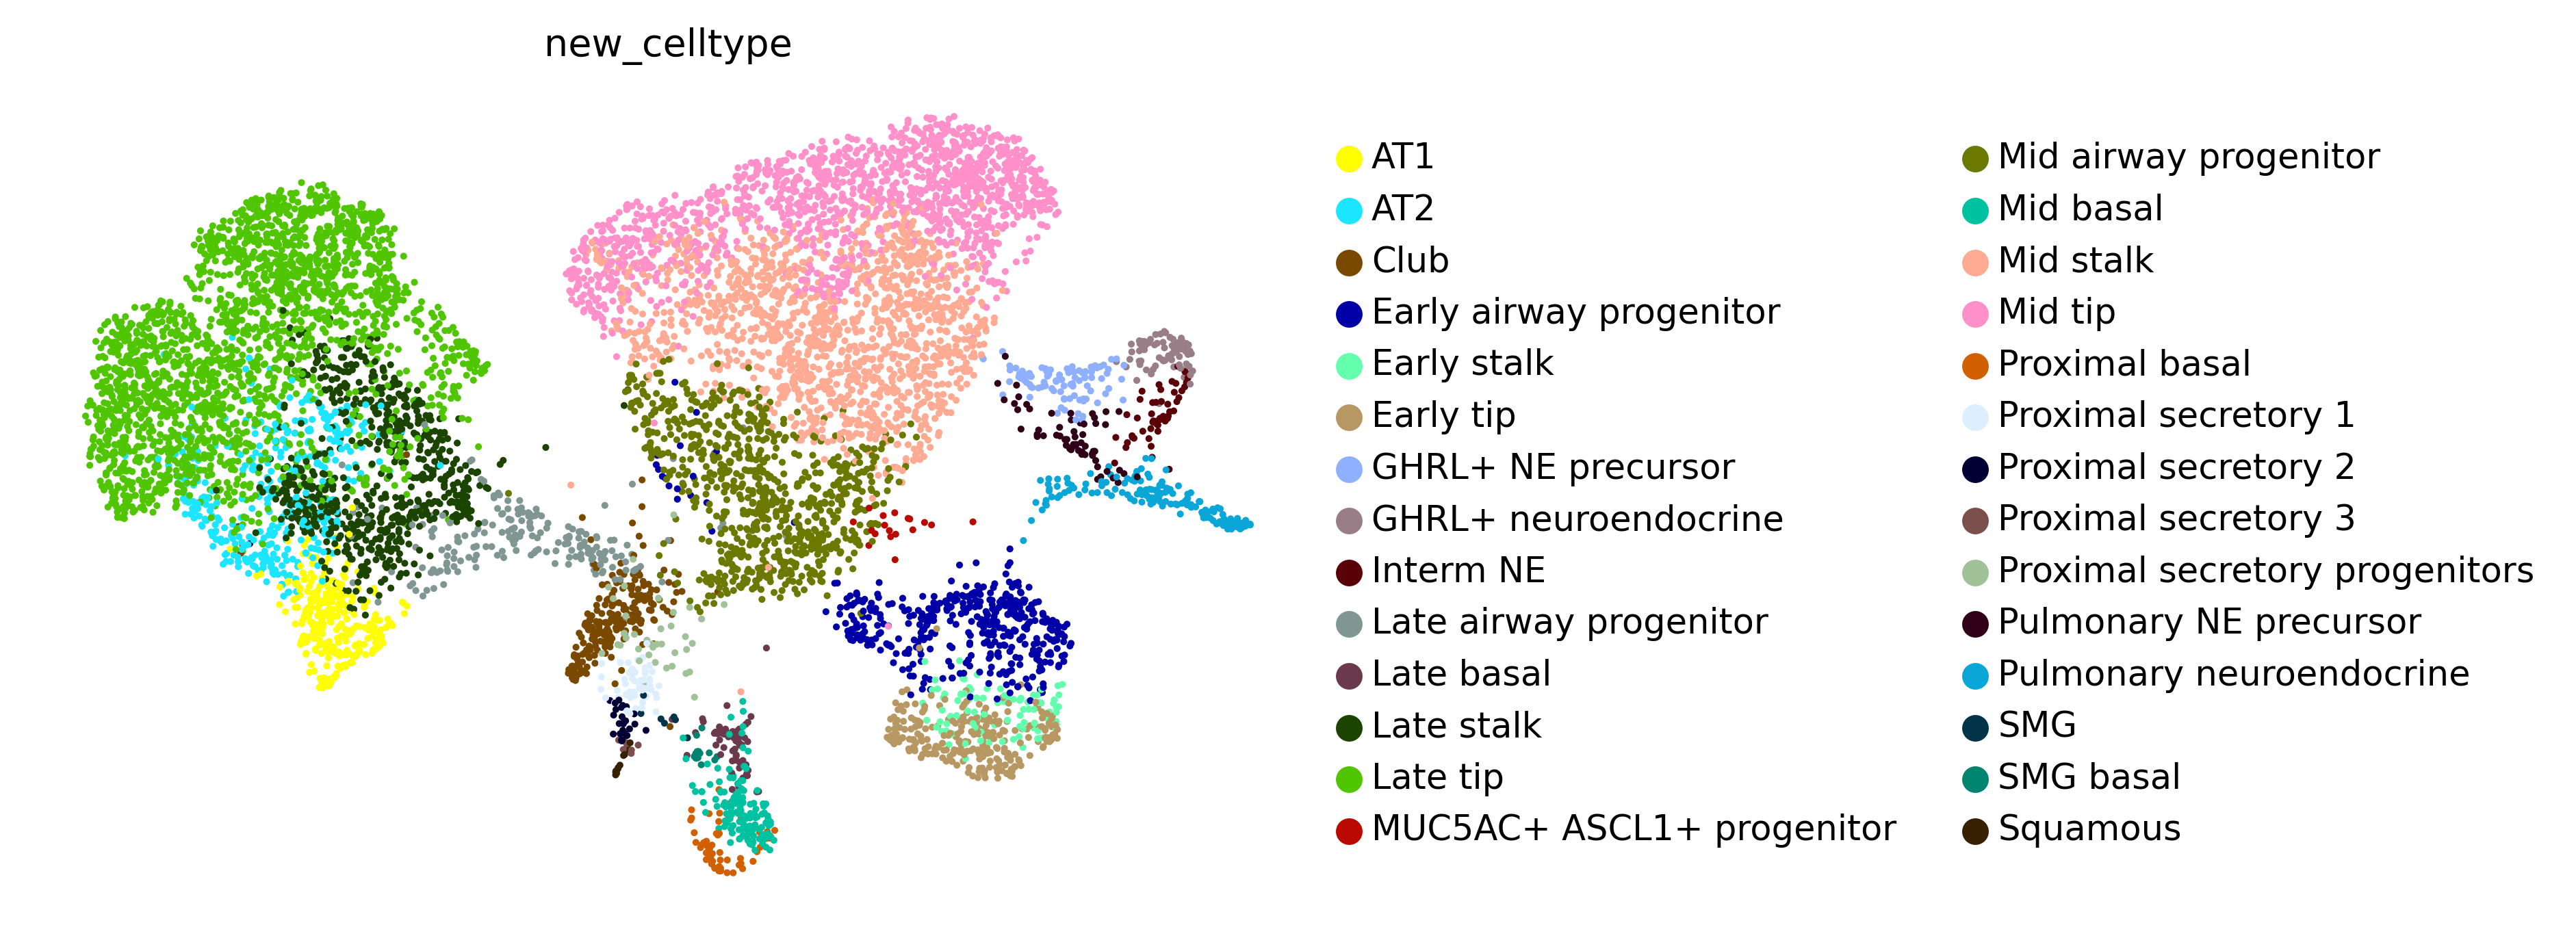

In [7]:
# sc.pl.pca_variance_ratio(adata, log=True)

# sc.pp.neighbors(adata, n_neighbors=20, use_rep='X_pca', n_pcs = 30)
# sc.tl.umap(adata)
# sc.pl.umap(adata,color='new_celltype')

In [15]:
data_dir = '/lustre/scratch126/cellgen/team292/ha10/data/Spatial_Lung/'
adata.write(data_dir+'adata_spatial_lung_processed.h5ad')

In [9]:
# adata = sc.read(data_dir+'adata_spatial_lung_processed.h5ad')

In [10]:
# adata = adata[:,adata.var.highly_variable]

## inVAE training

In [5]:
data_dir = '/lustre/scratch126/cellgen/team292/ha10/data/Spatial_Lung/'
adata = sc.read(data_dir+'adata_spatial_lung_processed.h5ad')
adata

AnnData object with n_obs × n_vars = 193108 × 4000
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [4]:
adata = adata[adata.obs.PoolDon.isin(['Pool1', 'Pool2', 'Pool3', 'Pool4', 'Pool5'])]

In [5]:
#sn
adata.obs['Loc_true'].unique()

['c_Bronchi.4', 'e_TopLeftPar', 'd_LowLeftPar', 'b_Bronchi.2.3', 'a_Trachea']
Categories (5, object): ['a_Trachea', 'b_Bronchi.2.3', 'c_Bronchi.4', 'd_LowLeftPar', 'e_TopLeftPar']

In [6]:
adata

View of AnnData object with n_obs × n_vars = 46325 × 4000
    obs: 'Celltypes', 'Celltypes_master_high', 'Celltypes_master_higher', 'Celltypes_master_higher_immune', 'Loc_true', 'Material', 'Donor', 'Donor_ID_2', 'Gender', 'Sample', 'ID', 'Protocol_plot', 'Version', 'Study', 'PoolDon', 'DonorPool', 'scDonor_snBatch', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [7]:
# Define covariates for the invariant and spurious prior in the following way/structure
# cat = categorical, cont = continuous

# Covariates for the invariant prior
inv_covar_keys = {
    'cont': [],
    'cat': ['Loc_true','Celltypes_master_higher_immune'] 
}

# Covariates for the spurious prior
spur_covar_keys = {
    'cont': [],
    'cat': ['PoolDon','Donor']
}

In [8]:
adata.layers['counts'] = adata.layers['counts'].astype(int)

In [9]:
# set the seeds for reproducibility
torch.manual_seed(100)
torch.cuda.manual_seed(100)
np.random.seed(100)

# train Factorized inVAE: FinVAE
model = FinVAE(
   adata = adata,
   layer = 'counts',
   inv_covar_keys = inv_covar_keys,
   spur_covar_keys = spur_covar_keys,
   inject_covar_in_latent= True,
   latent_dim_inv = 30, 
   latent_dim_spur = 0,
   n_layers = 2, 
   hidden_dim = 128,
   activation = 'relu', 
   slope = 0.1, # only needed when activation is Leaky ReLU ('lrelu')
   device = 'cuda', # or 'cpu' if no gpu is available
   normalize_constant = 1.0, 
   fix_mean_prior = False,
   fix_var_prior = True,
   decoder_dist = 'nb',
   batch_norm = True,
   kl_rate = 1.5,
   batch_size = 128,
   elbo_version = 'sample',
   batch_norm_prior = True,
   dropout_rate = 0.0
)


Injecting spurious covariates in the latent space! The latent_dim_spur are ignored and set to zero!
Data loading done!


In [30]:
model.train(
    n_epochs=150, 
    lr_train = 0.001, 
    weight_decay = 0.0001,
    log_dir = './test_invae/nf_invae',
    log_freq = 50, # in iterations
    print_every_n_epochs = 10
)

Starting training of model:
	epoch 10/150 took 2.82s; loss: 1025.59
	epoch 20/150 took 2.8s; loss: 1017.42
	epoch 30/150 took 2.81s; loss: 1013.86
	epoch 40/150 took 2.81s; loss: 1011.93
	epoch 50/150 took 2.81s; loss: 1010.59
	epoch 60/150 took 2.83s; loss: 1009.71
	epoch 70/150 took 2.81s; loss: 1009.07
	epoch 80/150 took 2.81s; loss: 1008.62
	epoch 90/150 took 2.8s; loss: 1008.13
	epoch 100/150 took 2.78s; loss: 1007.81
	epoch 110/150 took 2.81s; loss: 1007.35
	epoch 120/150 took 2.84s; loss: 1007.18
	epoch 130/150 took 2.81s; loss: 1006.99
	epoch 140/150 took 2.81s; loss: 1006.72
	epoch 150/150 took 2.79s; loss: 1006.61
Training done!


In [31]:
model.save('../models/model_spatial_lung_30_0_donor_pooldon_master_higher_immune.pt')

Saving the pytorch module...
To load the model later you need to save the hyperparameters in a separate file/dictionary.


# Data represenation

In [10]:
model.load('../models/model_spatial_lung_30_0_donor_pooldon_master_higher_immune.pt')

Loading the model from given checkpoint...


## Invariant data representation

In [11]:
latent = model.get_latent_representation(adata,latent_type='inv')

Calculating latent representation of passed adata by trying to transfer setup from the adata the model was trained on!


In [12]:
adata.obsm['X_FinVAE'] = latent

sc.pp.neighbors(adata, use_rep='X_FinVAE',n_neighbors=20)
sc.tl.umap(adata)

# adata.write(data_dir+'adata_train_inVAE_processed.h5ad')

/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/si

In [4]:
data_dir = '/lustre/scratch126/cellgen/team292/ha10/data/Spatial_Lung/'
#adata.write(data_dir+'adata_train_inVAE_processed.h5ad')
#adata = sc.read(data_dir+'adata_train_inVAE_processed.h5ad')

In [8]:
data_dir = '/lustre/scratch126/cellgen/team292/ha10/data/Spatial_Lung/'
adata = sc.read(data_dir+'adata_train_inVAE_processed.h5ad')

/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


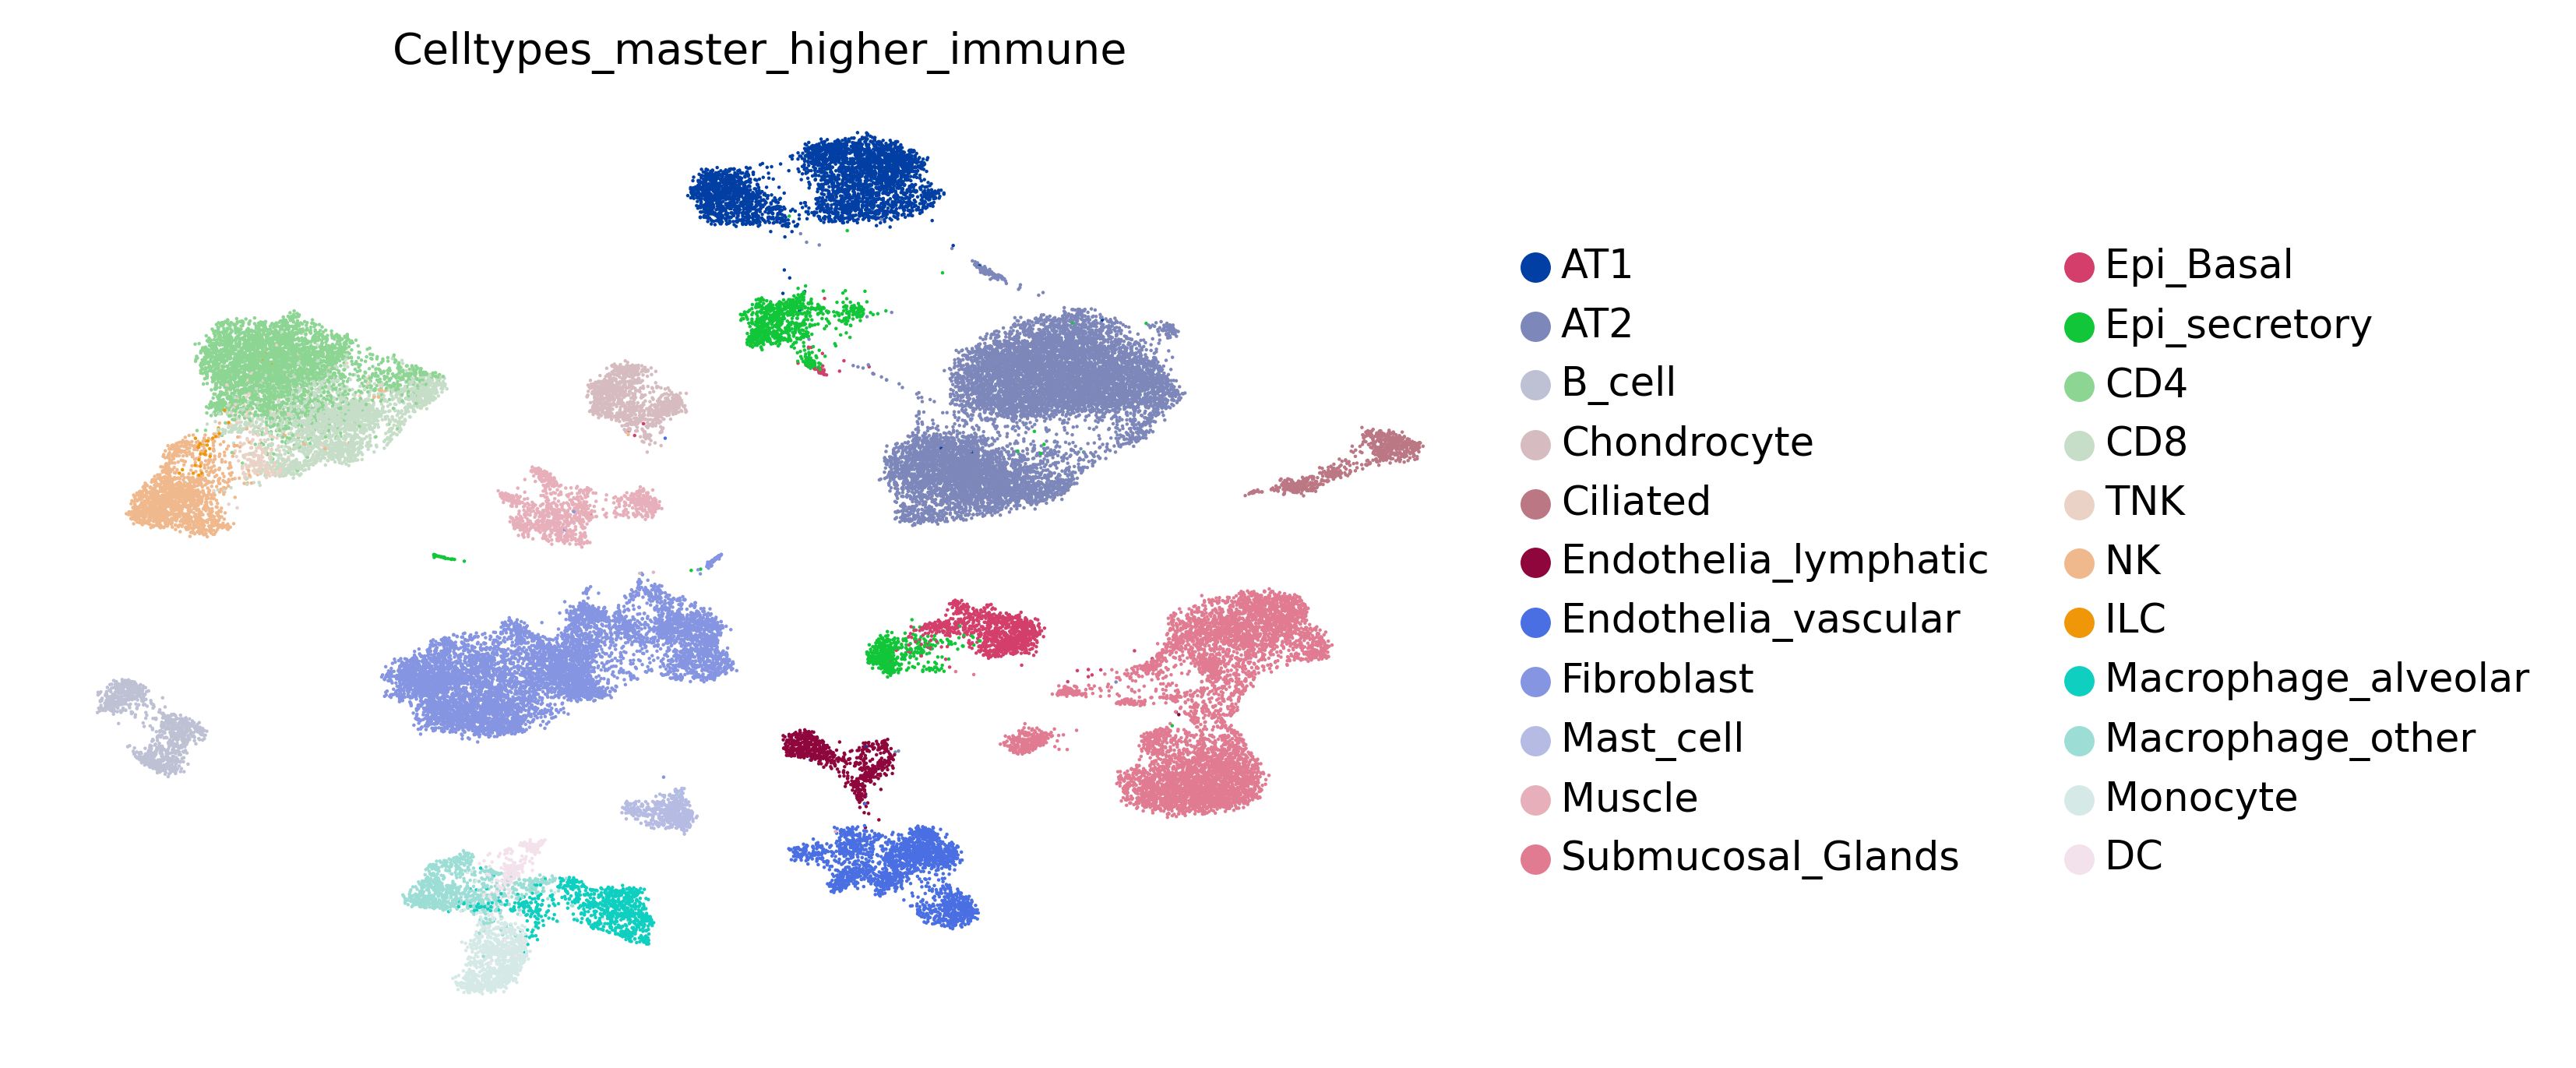

/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


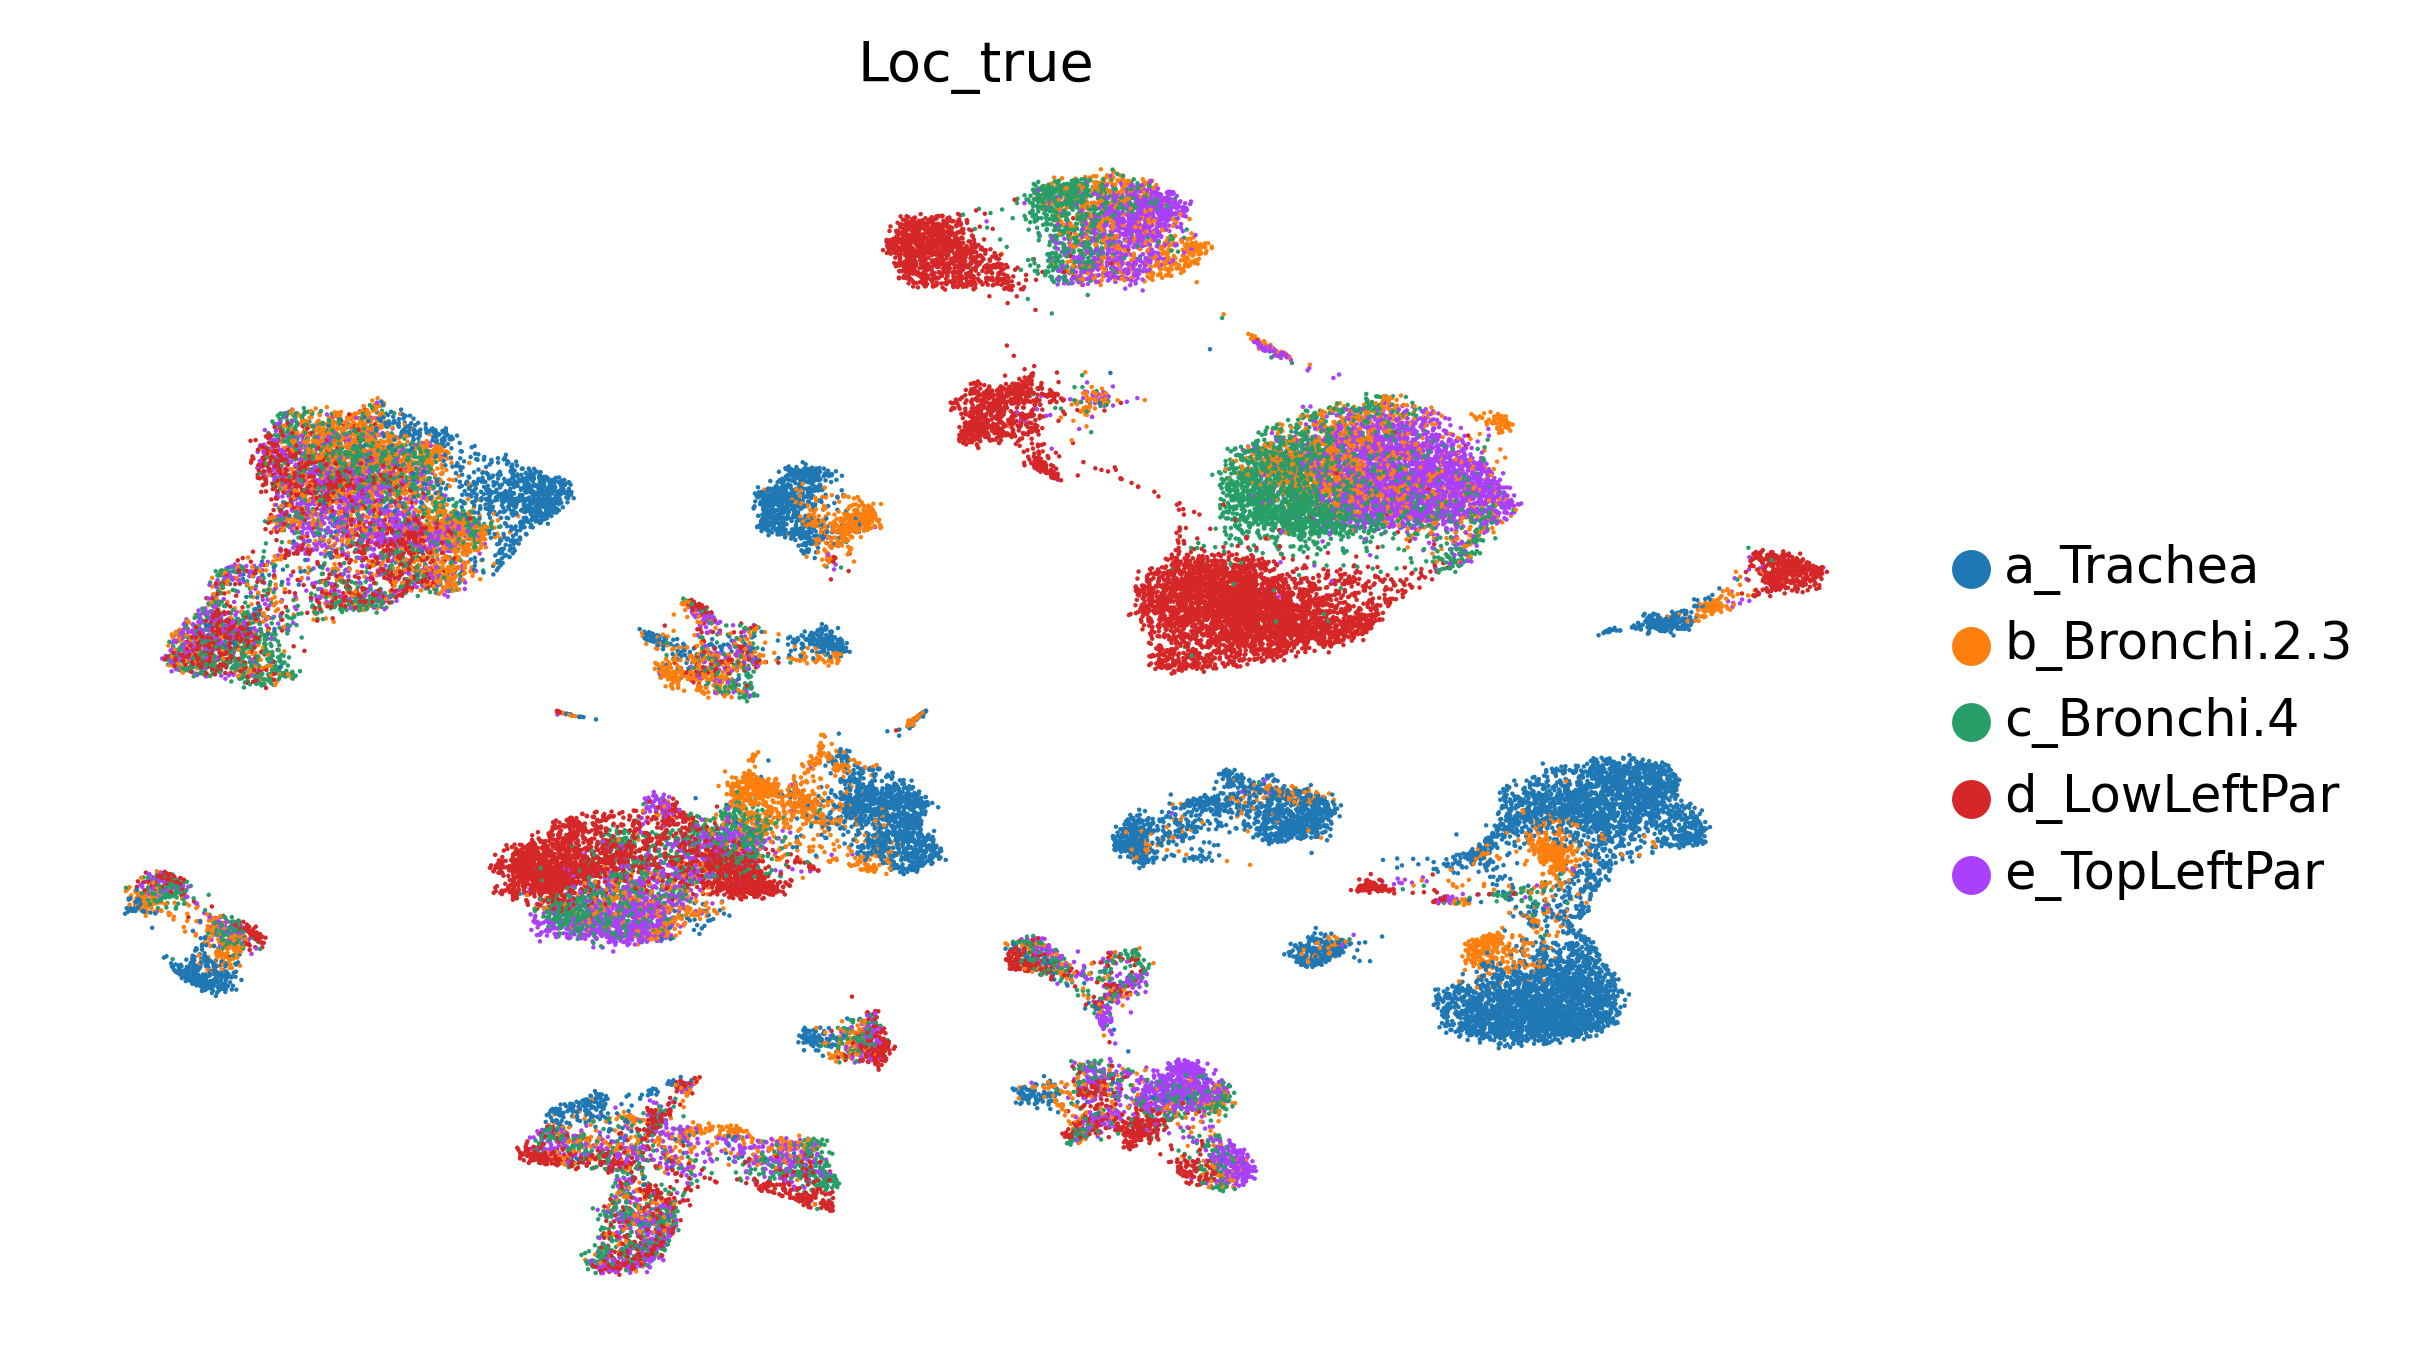

/nfs/team292/ha10/miniconda3/envs/data-an/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


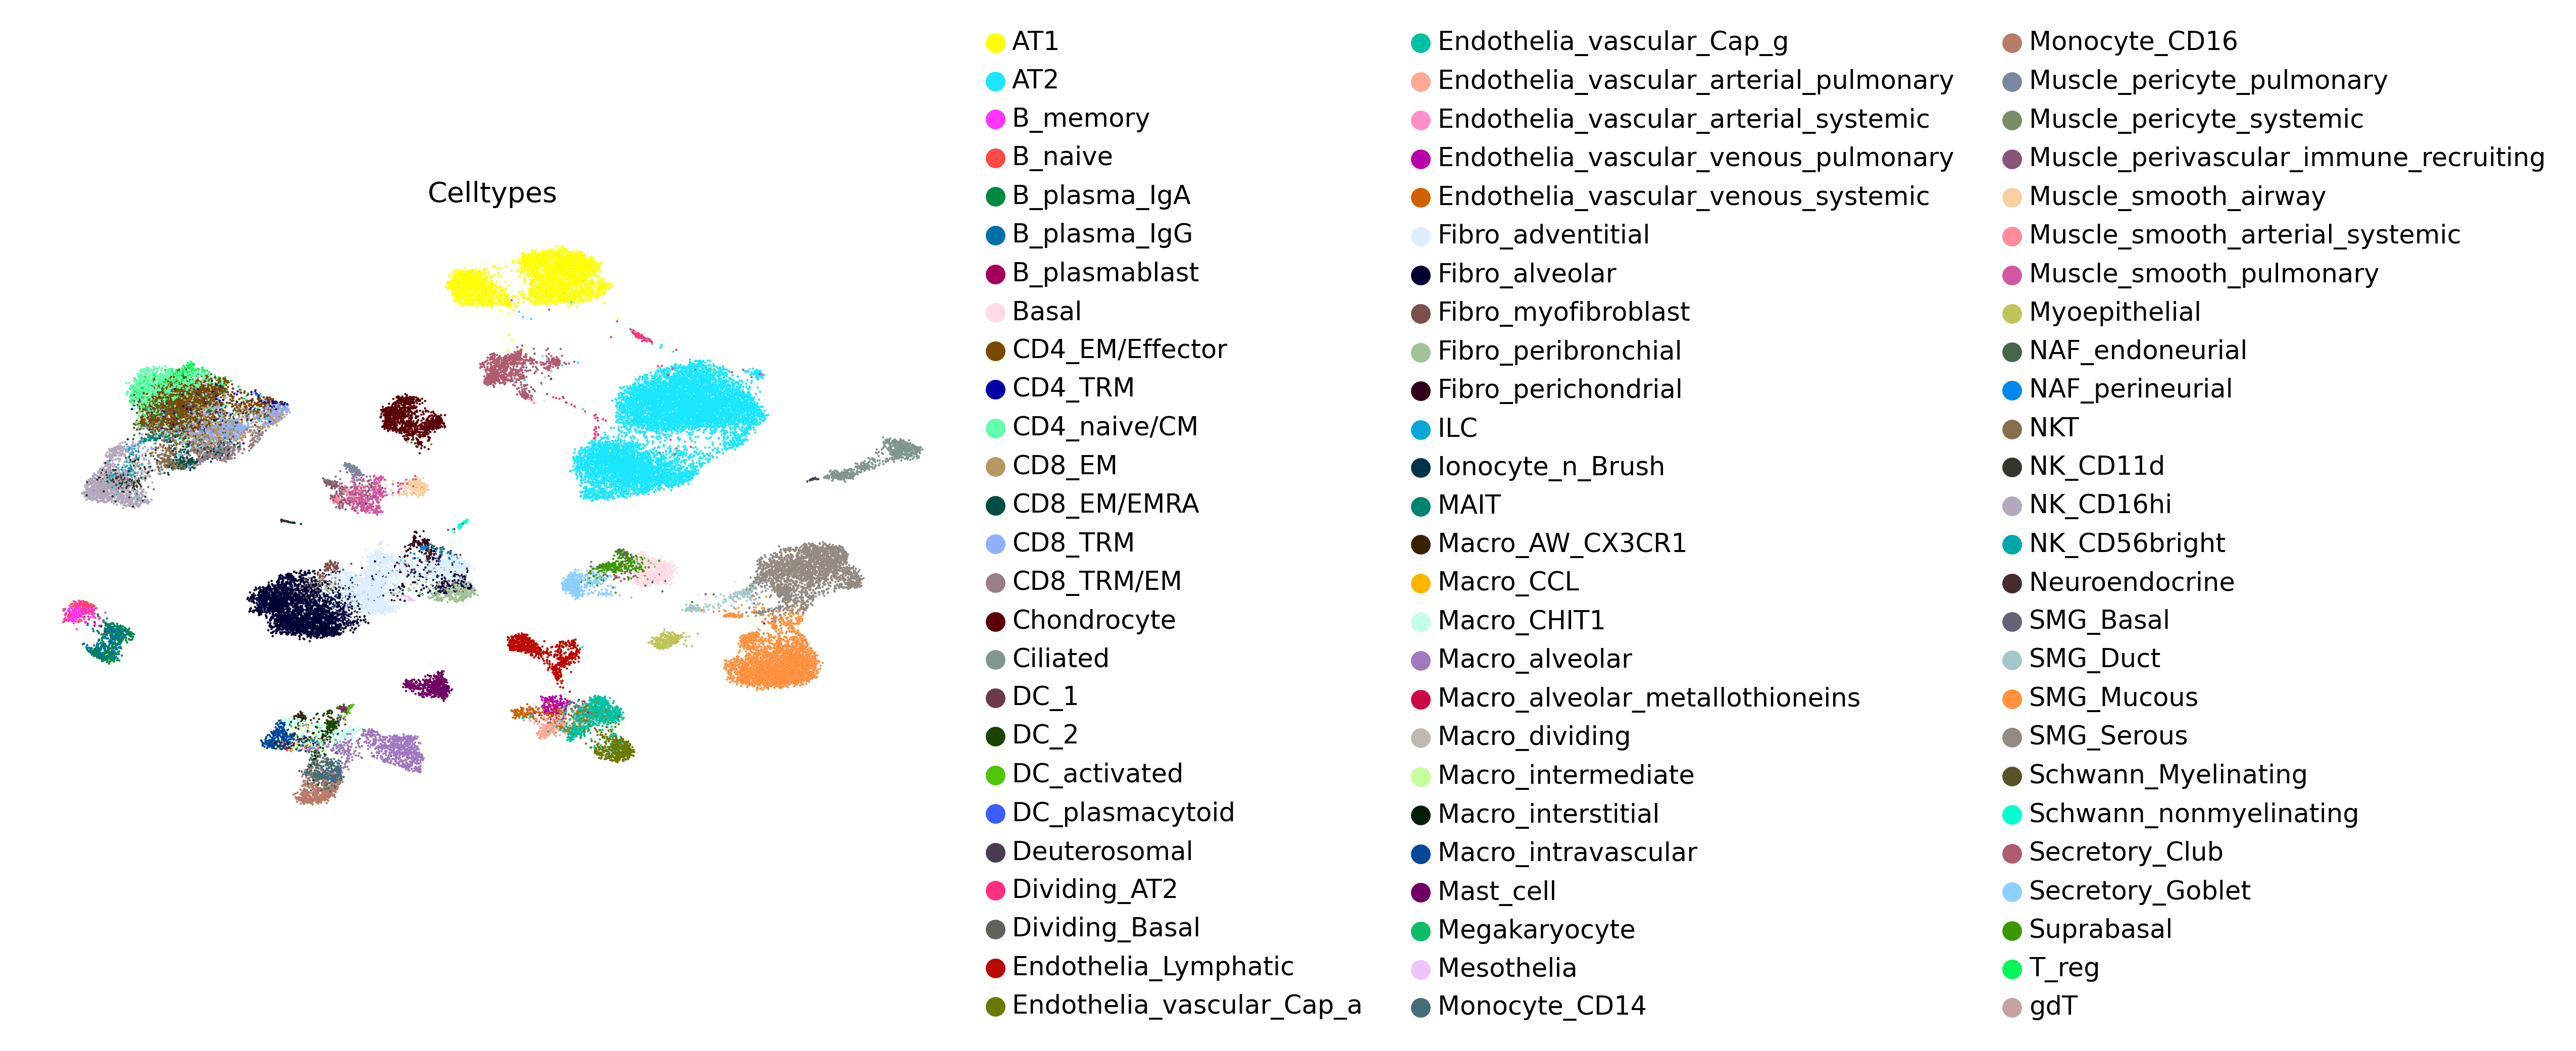

In [12]:
sc.pl.umap(adata,color='Celltypes_master_higher_immune',save='lung_spatial_coarse_celltype.pdf')
sc.pl.umap(adata,color='Loc_true',save='lung_spatial_Loc_true.pdf')
sc.pl.umap(adata,color='Celltypes',save='lung_spatial_celltype.pdf')